In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%cd /content/drive/MyDrive/misc/titanic/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/misc/titanic


In [ ]:
train = pd.read_csv('train.csv')
target = train.Survived.astype(np.float32)
# train = train.drop('Survived', axis=1)
test = pd.read_csv('test.csv')
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
N = train.shape[0]
# df = pd.concat([train, test], axis=0)
df = train

df['Title'] = df['Name'].map(lambda x: x.split(
    ',')[1].split('.')[0].split()[-1])

df['Exotic'] = ~df['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master'])
df['Title'] = np.where(df['Exotic'], 'Exotic', df['Title'])


In [ ]:
train['Cabin'] = (train.groupby('Ticket')['Cabin']
                  .apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
                  )


In [ ]:
df = pd.get_dummies(
    df, columns=['Embarked', 'Pclass', 'Sex', 'Title'])
train = df[:N]
test = df[N:]
train.dtypes


PassengerId       int64
Survived          int64
Name             object
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Exotic             bool
Embarked_C        uint8
Embarked_Q        uint8
Embarked_S        uint8
Pclass_1          uint8
Pclass_2          uint8
Pclass_3          uint8
Sex_female        uint8
Sex_male          uint8
Title_Exotic      uint8
Title_Master      uint8
Title_Miss        uint8
Title_Mr          uint8
Title_Mrs         uint8
dtype: object

In [ ]:
sns.heatmap(pd.DataFrame(target).join(train.drop('Survived', axis=1)).drop(
    'PassengerId', axis=1).corr(), cmap='jet')

In [ ]:
print(train.isnull().sum())
print(test.isnull().sum())


 Try to detect age.  We compare age to sex, passanger class, embarked, and fare.

In [ ]:
train.pipe((sns.FacetGrid, 'data'), col='Sex').map(sns.histplot, 'Age')
train.groupby('Sex')['Age'].mean()


In [ ]:
train.pipe((sns.FacetGrid, 'data'), col='Pclass').map(sns.histplot, 'Age')
train.groupby('Pclass')['Age'].mean()


In [ ]:
train.pipe((sns.FacetGrid, 'data'), col='Embarked').map(sns.histplot, 'Age')
train.groupby('Embarked')['Age'].mean()


In [ ]:
train.pipe((sns.FacetGrid, 'data'), sharex=False, sharey=False,
           col='Pclass').map(sns.histplot, 'Fare')
train.groupby('Pclass')['Fare'].mean()


In [ ]:
sns.scatterplot(data=train, x='Fare', y='Age')


In [ ]:
train[train['Pclass'].isin([2, 3])]['Fare'].max()

In [ ]:
train[train['Age'].isnull()]['Fare'].hist()


In [ ]:
train.groupby('Pclass')['Cabin'].apply(lambda x: x.isnull().sum())


In [ ]:
def process(df):
    if 'Survived' in df.columns:
        df = df.drop('Survived', axis=1)

    return (df
            .assign(NoAge=df.Age.isnull())
            .fillna(value={'Age': df.Age.mean(), 'Embarked': 'S', 'Fare': df.Fare.mean()})
            .assign(Cabin=df.Cabin.isnull())
            .drop(['PassengerId', 'Ticket', 'Name'], axis=1)
            )


train = process(train).astype(np.float32)
train.dtypes


Age             float32
SibSp           float32
Parch           float32
Fare            float32
Cabin           float32
Exotic          float32
Embarked_C      float32
Embarked_Q      float32
Embarked_S      float32
Pclass_1        float32
Pclass_2        float32
Pclass_3        float32
Sex_female      float32
Sex_male        float32
Title_Exotic    float32
Title_Master    float32
Title_Miss      float32
Title_Mr        float32
Title_Mrs       float32
NoAge           float32
dtype: object

In [ ]:
import tensorflow as tf


def build_model():
    return tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])



In [ ]:
import datetime
%load_ext tensorboard

model = build_model()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2),
              loss='binary_crossentropy',
              metrics=['accuracy'])

path = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=path, histogram_freq=1)


In [ ]:
history = model.fit(train, target, epochs=100,
                    validation_split=0.1, callbacks=[tensorboard_callback])


Epoch 1/100
26/26 [==============================] - 2s 26ms/step - loss: 0.8111 - accuracy: 0.5915 - val_loss: 0.6215 - val_accuracy: 0.6111
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 0.7383 - accuracy: 0.6183 - val_loss: 0.5891 - val_accuracy: 0.6889
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5871 - accuracy: 0.7237 - val_loss: 0.5622 - val_accuracy: 0.7000
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5985 - accuracy: 0.7008 - val_loss: 0.5315 - val_accuracy: 0.7222
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5595 - accuracy: 0.7269 - val_loss: 0.4998 - val_accuracy: 0.7778
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5139 - accuracy: 0.7736 - val_loss: 0.4695 - val_accuracy: 0.8333
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.5158 - accuracy: 0.7580 - val_loss: 0.4442 - val_accuracy: 0.8556
Epoch 8/100


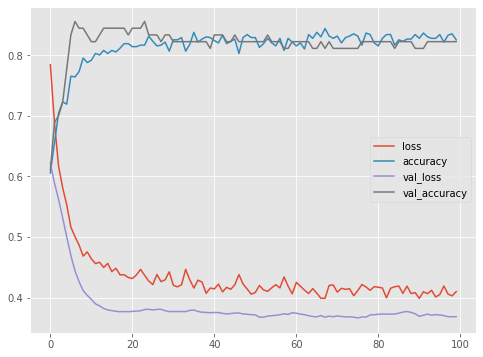

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 6))


In [ ]:
preds = model.predict(test.to_numpy().astype(np.float64)).round()


In [ ]:
x = pd.read_csv('test.csv')
sub = pd.DataFrame(
    {'PassengerId': x['PassengerId'], 'Survived': preds.astype(int).T[0]})
sub.to_csv('submission.csv', index=False)
sub.head()


In [3]:
from IPython.display import display, Markdown, Latex
display(Markdown('''![Image of a forest being cleared, representing industrial deforestation](https://ucsdnews.ucsd.edu/news_uploads/deforestation-2.jpg)

# Deforestation

The data this week comes from [Our World in Data](https://ourworldindata.org/forests-and-deforestation).

Hannah Ritchie and Max Roser (2021) - "Forests and Deforestation". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/forests-and-deforestation' [Online Resource]

Additional article from [UCSD and](https://ucsdnews.ucsd.edu/feature/deforestation-drives-disease-climate-change-and-its-happening-at-a-rapid-rate) about deforestation and its effects on climate change and disease.

There are a few datasets:  

- [Deforestation](https://ourworldindata.org/deforestation)  
- [Share of forest area](https://ourworldindata.org/forest-area)  
- [Drivers of deforestation](https://ourworldindata.org/drivers-of-deforestation)  
- [Deforestation by commodity](https://ourworldindata.org/grapher/deforestation-by-commodity)  
-[Soybean production and use](https://ourworldindata.org/soy)  
-[Palm oil production](https://ourworldindata.org/palm-oil)  

Quotes below from the Our World in Data articles:

> The net change in forest cover measures any gains in forest cover – either through natural forest expansion or afforestation through tree-planting – minus deforestation.

> How much of the world’s land surface today is covered by forest?
> 
> In the visualization we see the breakdown of global land area.
> 
> 10% of the world is covered by glaciers, and a further 19% is barren land – deserts, dry salt flats, beaches, sand dunes, and exposed rocks. This leaves what we call ‘habitable land’. 
>
> Forests account for a little over one-third (38%) of habitable land area. This is around one-quarter (26%) of total (both habitable and uninhabitable) land area.
>
> This marks a significant change from the past: global forest area has reduced significantly due to the expansion of agriculture. Today half of global habitable land is used for farming. The area used for livestock farming in particular is equal in area to the world’s forests.

> Every year the world loses around 5 million hectares of forest. 95% of this occurs in the tropics. At least three-quarters of this is driven by agriculture – clearing forests to grow crops, raise livestock and produce products such as paper.1
> 
> If we want to tackle deforestation we need to understand two key questions: where we’re losing forests, and what activities are driving it. This allows us to target our efforts towards specific industries, products, or countries where they will have the greatest impact.

> More than three-quarters (77%) of global soy is fed to livestock for meat and dairy production. Most of the rest is used for biofuels, industry or vegetable oils. Just 7% of soy is used directly for human food products such as tofu, soy milk, edamame beans, and tempeh. The idea that foods often promoted as substitutes for meat and dairy – such as tofu and soy milk – are driving deforestation is a common misconception.
>
> In this article I address some key questions about palm oil production: how has it changed; where is it grown; and how this has affected deforestation and biodiversity. The story of palm oil is not as simple as it is often portrayed. Global demand for vegetable oils has increased rapidly over the last 50 years. Being the most productive oilcrop, palm has taken up a lot of this production. This has had a negative impact on the environment, particularly in Indonesia and Malaysia. But it’s not clear that the alternatives would have fared any better. In fact, because we can produce up to 20 times as much oil per hectare from palm versus the alternatives, it has probably spared a lot of environmental impacts from elsewhere.

### Get the data here

```{r}
# Get the Data

# Read in with tidytuesdayR package 
# Install from CRAN via: install.packages("tidytuesdayR")
# This loads the readme and all the datasets for the week of interest

# Either ISO-8601 date or year/week works!

tuesdata <- tidytuesdayR::tt_load('2021-04-06')
tuesdata <- tidytuesdayR::tt_load(2021, week = 15)

forest_change <- tuesdata$forest_change

# Or read in the data manually

forest <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-06/forest.csv')
forest_area <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-06/forest_area.csv')
brazil_loss <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-06/brazil_loss.csv')
soybean_use <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-06/soybean_use.csv')
vegetable_oil <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-06/vegetable_oil.csv')

```
### Data Dictionary

# `forest.csv`

Change every 5 years for forest area in conversion.

|variable              |class     |description |
|:---------------------|:---------|:-----------|
|entity                |character | Country |
|code                  |character | Country code |
|year                  |double    | Year |
|net_forest_conversion |double    | Net forest conversion in hectares|

# `forest_area.csv`

Change in global forest area as a percent of global forest area.

|variable    |class     |description |
|:-----------|:---------|:-----------|
|entity      |character | Country|
|code        |character | Country Code |
|year        |integer   | Year |
|forest_area |double    | Percent of global forest area |

# `brazil_loss.csv`

Loss of Brazilian forest due to specific types.

|variable                        |class     |description |
|:-------------------------------|:---------|:-----------|
|entity                          |character | Country |
|code                            |character | Country code |
|year                            |double    | Year |
|commercial_crops                |double    | Commercial crops |
|flooding_due_to_dams            |double    | Flooding |
|natural_disturbances            |double    | Natural disturbances |
|pasture                         |double    | Pasture for livestock |
|selective_logging               |double    | Logging for lumber |
|fire                            |double    | Fire loss |
|mining                          |double    | Mining|
|other_infrastructure            |double    | Infrastructure |
|roads                           |double    | Roads |
|tree_plantations_including_palm |double    | Tree plantations |
|small_scale_clearing            |double    | Small scale clearing |

# `soybean_use.csv`

Soybean production and use by year and country.

|variable    |class     |description |
|:-----------|:---------|:-----------|
|entity      |character | Country|
|code        |character | Country Code |
|year        |double    | Year |
|human_food  |double    | Use for human food (tempeh, tofu, etc) |
|animal_feed |double    | Used for animal food |
|processed   |double    | Processed into vegetable oil, biofuel, processed animal feed |

# `vegetable_oil.csv`

Vegetable oil production by crop type and year.

|variable   |class     |description |
|:----------|:---------|:-----------|
|entity     |character | Country |
|code       |character | Country code |
|year       |double    | Year |
|crop_oil   |character | Crop that was used to produce vegetable oil |
|production |double    | Oil production in tonnes |

### Cleaning Script

Just renaming of columns this week.'''))
# If you particularly want to display maths, this is more direct:

![Image of a forest being cleared, representing industrial deforestation](https://ucsdnews.ucsd.edu/news_uploads/deforestation-2.jpg)

# Deforestation

The data this week comes from [Our World in Data](https://ourworldindata.org/forests-and-deforestation).

Hannah Ritchie and Max Roser (2021) - "Forests and Deforestation". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/forests-and-deforestation' [Online Resource]

Additional article from [UCSD and](https://ucsdnews.ucsd.edu/feature/deforestation-drives-disease-climate-change-and-its-happening-at-a-rapid-rate) about deforestation and its effects on climate change and disease.

There are a few datasets:  

- [Deforestation](https://ourworldindata.org/deforestation)  
- [Share of forest area](https://ourworldindata.org/forest-area)  
- [Drivers of deforestation](https://ourworldindata.org/drivers-of-deforestation)  
- [Deforestation by commodity](https://ourworldindata.org/grapher/deforestation-by-commodity)  
-[Soybean production and use](https://ourworldindata.org/soy)  
-[Palm oil production](https://ourworldindata.org/palm-oil)  

Quotes below from the Our World in Data articles:

> The net change in forest cover measures any gains in forest cover – either through natural forest expansion or afforestation through tree-planting – minus deforestation.

> How much of the world’s land surface today is covered by forest?
> 
> In the visualization we see the breakdown of global land area.
> 
> 10% of the world is covered by glaciers, and a further 19% is barren land – deserts, dry salt flats, beaches, sand dunes, and exposed rocks. This leaves what we call ‘habitable land’. 
>
> Forests account for a little over one-third (38%) of habitable land area. This is around one-quarter (26%) of total (both habitable and uninhabitable) land area.
>
> This marks a significant change from the past: global forest area has reduced significantly due to the expansion of agriculture. Today half of global habitable land is used for farming. The area used for livestock farming in particular is equal in area to the world’s forests.

> Every year the world loses around 5 million hectares of forest. 95% of this occurs in the tropics. At least three-quarters of this is driven by agriculture – clearing forests to grow crops, raise livestock and produce products such as paper.1
> 
> If we want to tackle deforestation we need to understand two key questions: where we’re losing forests, and what activities are driving it. This allows us to target our efforts towards specific industries, products, or countries where they will have the greatest impact.

> More than three-quarters (77%) of global soy is fed to livestock for meat and dairy production. Most of the rest is used for biofuels, industry or vegetable oils. Just 7% of soy is used directly for human food products such as tofu, soy milk, edamame beans, and tempeh. The idea that foods often promoted as substitutes for meat and dairy – such as tofu and soy milk – are driving deforestation is a common misconception.
>
> In this article I address some key questions about palm oil production: how has it changed; where is it grown; and how this has affected deforestation and biodiversity. The story of palm oil is not as simple as it is often portrayed. Global demand for vegetable oils has increased rapidly over the last 50 years. Being the most productive oilcrop, palm has taken up a lot of this production. This has had a negative impact on the environment, particularly in Indonesia and Malaysia. But it’s not clear that the alternatives would have fared any better. In fact, because we can produce up to 20 times as much oil per hectare from palm versus the alternatives, it has probably spared a lot of environmental impacts from elsewhere.

### Get the data here

```{r}
# Get the Data

# Read in with tidytuesdayR package 
# Install from CRAN via: install.packages("tidytuesdayR")
# This loads the readme and all the datasets for the week of interest

# Either ISO-8601 date or year/week works!

tuesdata <- tidytuesdayR::tt_load('2021-04-06')
tuesdata <- tidytuesdayR::tt_load(2021, week = 15)

forest_change <- tuesdata$forest_change

# Or read in the data manually

forest <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-06/forest.csv')
forest_area <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-06/forest_area.csv')
brazil_loss <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-06/brazil_loss.csv')
soybean_use <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-06/soybean_use.csv')
vegetable_oil <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-06/vegetable_oil.csv')

```
### Data Dictionary

# `forest.csv`

Change every 5 years for forest area in conversion.

|variable              |class     |description |
|:---------------------|:---------|:-----------|
|entity                |character | Country |
|code                  |character | Country code |
|year                  |double    | Year |
|net_forest_conversion |double    | Net forest conversion in hectares|

# `forest_area.csv`

Change in global forest area as a percent of global forest area.

|variable    |class     |description |
|:-----------|:---------|:-----------|
|entity      |character | Country|
|code        |character | Country Code |
|year        |integer   | Year |
|forest_area |double    | Percent of global forest area |

# `brazil_loss.csv`

Loss of Brazilian forest due to specific types.

|variable                        |class     |description |
|:-------------------------------|:---------|:-----------|
|entity                          |character | Country |
|code                            |character | Country code |
|year                            |double    | Year |
|commercial_crops                |double    | Commercial crops |
|flooding_due_to_dams            |double    | Flooding |
|natural_disturbances            |double    | Natural disturbances |
|pasture                         |double    | Pasture for livestock |
|selective_logging               |double    | Logging for lumber |
|fire                            |double    | Fire loss |
|mining                          |double    | Mining|
|other_infrastructure            |double    | Infrastructure |
|roads                           |double    | Roads |
|tree_plantations_including_palm |double    | Tree plantations |
|small_scale_clearing            |double    | Small scale clearing |

# `soybean_use.csv`

Soybean production and use by year and country.

|variable    |class     |description |
|:-----------|:---------|:-----------|
|entity      |character | Country|
|code        |character | Country Code |
|year        |double    | Year |
|human_food  |double    | Use for human food (tempeh, tofu, etc) |
|animal_feed |double    | Used for animal food |
|processed   |double    | Processed into vegetable oil, biofuel, processed animal feed |

# `vegetable_oil.csv`

Vegetable oil production by crop type and year.

|variable   |class     |description |
|:----------|:---------|:-----------|
|entity     |character | Country |
|code       |character | Country code |
|year       |double    | Year |
|crop_oil   |character | Crop that was used to produce vegetable oil |
|production |double    | Oil production in tonnes |

### Cleaning Script

Just renaming of columns this week.

In [5]:
Markdown?